# Dependency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

In [2]:
!mash --version

2.2.2


# Benchmarking

## Input data and constants

In [3]:
input_dir = 'input'
input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

nproc=4
kmer=31
sketch_size=1000

mash_dir = 'mash-data'

sample_sizes = [1,10,20,30,40,50,60,70,80]

benchmark.create_folder_if_doesnt_exist(mash_dir)

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS994', 'MOD1_LS995', 'MOD1_LS996', 'MOD1_LS997', 'MOD1_LS998', 'PNUSA000194', 'PNUSA000195', 'PNUSA000196', 'PNUSAL000730', 'PNUSAL000870', 'PNUSAL000957', 'PNUSAL001024', 'SIM_CFSAN000189', 'SIM_CFSAN000191', 'SIM_CFSAN000211', 'SIM_CFSAN000212', 'SIM_CFSAN000228', 'SIM_CFSAN000661', 'SIM_CFSAN000669', 'SIM_CFSAN000700', 'SIM_CFSAN000752', 'SIM_

## Benchmark functions

In [4]:
def reset_func():
    benchmark.clean_if_exists(mash_dir)
    
def sampling_func(sample_size):
    samples = input_samples[:sample_size]
    return samples
    
mash_command = {
    "command": f"mash sketch -r -p 1 -s {sketch_size} -k {kmer} -I % -o {mash_dir}/%.msh {input_dir}/%_1.fastq.gz {input_dir}/%_2.fastq.gz",
    "parallel_args": f"-j {nproc} -I%",
}

combine_sketchs_command = {
    "command": lambda inputs: f"mash paste {mash_dir}/sketches " + ' '.join([f"{mash_dir}/{x}.msh" for x in inputs]),
}

dist_calculation_times = 1
dist_calculating_genome = "2014C-3600_1.fastq.gz"

query_command = {
    "command": f"mash dist -p {nproc} {mash_dir}/sketches.msh {input_dir}/%",
    "parallel_args": "-j 1 -I%",
    "parallel_argfiles": [dist_calculating_genome] * dist_calculation_times
}

## Benchmark

In [5]:
multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "index": [mash_command, combine_sketchs_command],
        "query": [query_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
parallel -j 4 -I% mash sketch -r -p 1 -s 1000 -k 31 -I % -o mash-data/%.msh input/%_1.fastq.gz input/%_2.fastq.gz ::: 2014C-3598

STDOUT: 
-------------
STDERR: WARNING: The option p will be ignored with r.
Estimated genome size: 3.22011e+07
Estimated coverage:    6.456
Writing to mash-data/2014C-3598.msh...

<<<<<<<<<<<<<

>>>>>>>>>>>>>
mash paste mash-data/sketches mash-data/2014C-3598.msh

STDOUT: 
-------------
STDERR: Writing mash-data/sketches.msh...

<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 1 -I% mash dist -p 4 mash-data/sketches.msh input/% ::: 2014C-3600_1.fastq.gz

STDOUT: 2014C-3598	input/2014C-3600_1.fastq.gz	0.0454931	0	139/1000

-------------
STDERR: 
<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 4 -I% mash sketch -r -p 1 -s 1000 -k 31 -I % -o mash-data/%.msh input/%_1.fastq.gz input/%_2.fastq.gz ::: 2014C-3598 2014C-3599 2014C-3600 2014C-3655 2014C-3656 2014C-3840 2014C-3850 2014C-3857 2014C-3907 2014D-0067

STDOUT: 
-------------
STDERR: WARNING: The option p w

# Save and reload results

In [6]:
save_path = "mash-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)
multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)

# Plot

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 13.54, 'memory': 30068736.0, 'disk_read': 182609743.0, 'disk_write': 790912.0}, {'runtime': 59.9, 'memory': 64450560.0, 'disk_read': 2676101827.0, 'disk_write': 1928180.0}, {'runtime': 92.12, 'memory': 64442368.0, 'disk_read': 4754238997.0, 'disk_write': 3233805.0}, {'runtime': 195.99, 'memory': 64307200.0, 'disk_read': 9290633337.0, 'disk_write': 5104472.0}, {'runtime': 283.3, 'memory': 64434176.0, 'disk_read': 14383111686.0, 'disk_write': 6663725.0}, {'runtime': 337.62, 'memory': 64462848.0, 'disk_read': 17349496459.0, 'disk_write': 8165832.0}, {'runtime': 398.66, 'memory': 64495616.0, 'disk_read': 20481146178.0, 'disk_write': 9561426.0}, {'runtime': 424.21, 'memory': 64688128.0, 'disk_read': 22197050751.0, 'disk_write': 10981892.0}, {'runtime': 453.19, 'memory': 64737280.0, 'disk_read': 23918636585.0, 'disk_write': 12336878.0}]


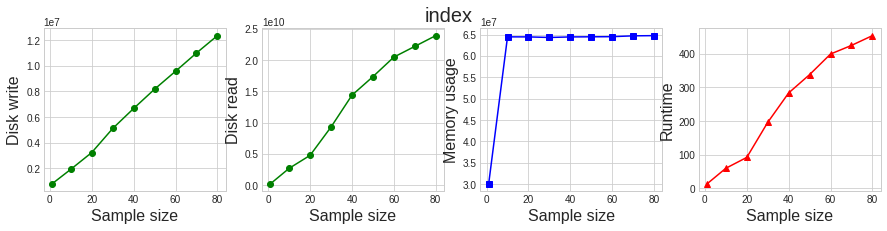

In [8]:
# Indexing Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 17.77, 'memory': 30887936.0, 'disk_read': 238015928.0, 'disk_write': 811261.0}, {'runtime': 18.81, 'memory': 31428608.0, 'disk_read': 238015357.0, 'disk_write': 820544.0}, {'runtime': 17.77, 'memory': 31436800.0, 'disk_read': 238017018.0, 'disk_write': 813433.0}, {'runtime': 18.77, 'memory': 31387648.0, 'disk_read': 238017557.0, 'disk_write': 822702.0}, {'runtime': 18.9, 'memory': 31281152.0, 'disk_read': 238018119.0, 'disk_write': 823830.0}, {'runtime': 19.3, 'memory': 31617024.0, 'disk_read': 238017581.0, 'disk_write': 833171.0}, {'runtime': 19.13, 'memory': 32100352.0, 'disk_read': 238017335.0, 'disk_write': 826160.0}, {'runtime': 18.51, 'memory': 32096256.0, 'disk_read': 238018847.0, 'disk_write': 827512.0}, {'runtime': 19.3, 'memory': 32133120.0, 'disk_read': 238019503.0, 'disk_write': 837007.0}]


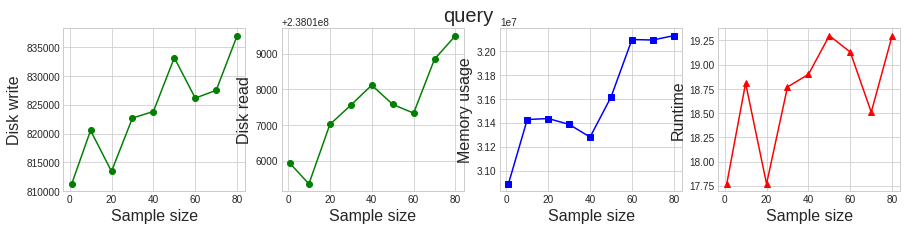

In [9]:
# Querying Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "query")